In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

import collections
import itertools

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly as py
import plotly.graph_objs as go

import scipy.stats as stats
from scipy.stats import norm
from scipy.special import boxcox1p

import statsmodels
import statsmodels.api as sm
#print(statsmodels.__version__)

from sklearn.preprocessing import scale, StandardScaler, RobustScaler, OneHotEncoder
from sklearn.utils import resample
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import colorlover as cl
from IPython.display import HTML

chosen_colors=cl.scales['7']['qual'][np.random.choice(list(cl.scales['7']['qual'].keys()))]

print('The color palette chosen for this notebook is:')
HTML(cl.to_html(chosen_colors))


The color palette chosen for this notebook is:


In [2]:
pip install colorlover

Note: you may need to restart the kernel to use updated packages.


# Load data

In [4]:
Combined_data = pd.read_csv('AB_NYC_2019.csv')
Combined_data.head()

id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  2018-10-19   
1  Entire home/apt    225               1                 45  2019-05-21   
2     Private room    150               3                  0         NaN   
3  Entire home/apt     89               1                270  2019-07-05   
4  Entire home/apt     80              10                  9  2018-11-19   

   reviews_per_month  calculated_host_listings_count  availability_365  
0               0.21                               6               365  
1               0.38                               2               355  
2                NaN                               1               365  
3               4.64                               1               194  
4               0.10                               1                 0

In [5]:
print('Number of features: {}'.format(Combined_data.shape[1]))
print('Number of examples: {}'.format(Combined_data.shape[0]))

Number of features: 16
Number of examples: 48895


In [6]:
#for c in df.columns:
#    print(c, dtype(df_train[c]))
Combined_data.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [7]:
Combined_data['last_review'] = pd.to_datetime(Combined_data['last_review'],infer_datetime_format=True) 

# Input processing

### Missing data

In [8]:
total = Combined_data.isnull().sum().sort_values(ascending=False)
percent = (Combined_data.isnull().sum())/Combined_data.isnull().count().sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'], sort=False).sort_values('Total', ascending=False)
missing_data.head(40)

Total   Percent
reviews_per_month               10052  0.205583
last_review                     10052  0.205583
host_name                          21  0.000429
name                               16  0.000327
availability_365                    0  0.000000
calculated_host_listings_count      0  0.000000
number_of_reviews                   0  0.000000
minimum_nights                      0  0.000000
price                               0  0.000000
room_type                           0  0.000000
longitude                           0  0.000000
latitude                            0  0.000000
neighbourhood                       0  0.000000
neighbourhood_group                 0  0.000000
host_id                             0  0.000000
id                                  0  0.000000

In [9]:
Combined_data.drop(['host_name','name'], axis=1, inplace=True)

In [10]:
Combined_data[Combined_data['number_of_reviews']== 0.0].shape

(10052, 14)

The NaN values in the last_review and reviews_per_month columns all occur for examples where no reviews were given in the first place. 

For reviews_per_month, I will fill those values with 0's.

In [11]:
Combined_data['reviews_per_month'] = Combined_data['reviews_per_month'].fillna(0)

In [12]:
earliest = min(Combined_data['last_review'])
Combined_data['last_review'] = Combined_data['last_review'].fillna(earliest)
Combined_data['last_review'] = Combined_data['last_review'].apply(lambda x: x.toordinal() - earliest.toordinal())

In [13]:
earliest

Timestamp('2011-03-28 00:00:00')

In [14]:
Combined_data['last_review']

0        2762
1        2976
2           0
3        3021
4        2793
         ... 
48890       0
48891       0
48892       0
48893       0
48894       0
Name: last_review, Length: 48895, dtype: int64

In [15]:
total = Combined_data.isnull().sum().sort_values(ascending=False)
percent = (Combined_data.isnull().sum())/Combined_data.isnull().count().sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total','Percent'], sort=False).sort_values('Total', ascending=False)
missing_data.head(40)

Total  Percent
availability_365                    0      0.0
calculated_host_listings_count      0      0.0
reviews_per_month                   0      0.0
last_review                         0      0.0
number_of_reviews                   0      0.0
minimum_nights                      0      0.0
price                               0      0.0
room_type                           0      0.0
longitude                           0      0.0
latitude                            0      0.0
neighbourhood                       0      0.0
neighbourhood_group                 0      0.0
host_id                             0      0.0
id                                  0      0.0

### Outliers & input transformations

See my rental price prediction notebook for details!


In [16]:
Combined_data = Combined_data[np.log1p(Combined_data['price']) < 8]
Combined_data = Combined_data[np.log1p(Combined_data['price']) > 3]
Combined_data['price'] = np.log1p(Combined_data['price'])

Combined_data = Combined_data.drop(['host_id', 'id'], axis=1)

Combined_data['minimum_nights'] = np.log1p(Combined_data['minimum_nights'])

Combined_data['reviews_per_month'] = Combined_data[Combined_data['reviews_per_month'] < 17.5]['reviews_per_month']

#### Categorical features

In [17]:
categorical_features = Combined_data.select_dtypes(include=['object'])
print('Categorical features: {}'.format(categorical_features.shape))
categorical_features_one_hot = pd.get_dummies(categorical_features)
categorical_features_one_hot.head()
Combined_data['reviews_per_month'] = Combined_data['reviews_per_month'].fillna(0)

numerical_features =  Combined_data.select_dtypes(exclude=['object'])
y = numerical_features.price
numerical_features = numerical_features.drop(['price'], axis=1)
print('Numerical features: {}'.format(numerical_features.shape))


Categorical features: (48784, 3)
Numerical features: (48784, 8)


In [18]:
X = np.concatenate((numerical_features, categorical_features_one_hot), axis=1)
X_df = pd.concat([numerical_features, categorical_features_one_hot], axis=1)
#print('Dimensions of the design matrix: {}'.format(X.shape))
#print('Dimension of the target vector: {}'.format(y.shape))

Processed_data = pd.concat([X_df, y], axis = 1)
#Processed_data.to_csv('NYC_Airbnb_Processed.dat')

### Scaling

In [19]:
scaler = RobustScaler()
scaler.fit(X)
X = scaler.transform(X)
X;

# PCA

In [20]:
pca = PCA()
X_pca = pca.fit_transform(X);
pca.get_covariance();

explained_variance = pca.explained_variance_ratio_
explained_variance = pd.DataFrame({'PCA Component': [1+x for x in range(len(explained_variance))], 'Explained Variance': explained_variance})
explained_variance.head()

PCA Component  Explained Variance
0              1            0.990662
1              2            0.003996
2              3            0.001050
3              4            0.000838
4              5            0.000771

In [23]:
explained_variance

PCA Component  Explained Variance
0                1        9.906617e-01
1                2        3.996263e-03
2                3        1.050415e-03
3                4        8.377595e-04
4                5        7.706488e-04
..             ...                 ...
232            233        6.381676e-33
233            234        6.381676e-33
234            235        6.381676e-33
235            236        6.381676e-33
236            237        2.207713e-36

[237 rows x 2 columns]

In [21]:
n_components = 50
trace1 = go.Scatter(
    x=explained_variance["PCA Component"][:n_components], 
    y=100*explained_variance["Explained Variance"][:n_components],
    
    mode='markers',
    line=dict(
        color='red'
    ),
)

trace2 = go.Scatter(
    x=explained_variance["PCA Component"][:n_components], 
    y=100*explained_variance["Explained Variance"][:n_components],
    
    mode='lines',
    line=dict(
        color='red'
    ),
)

data=[trace1, trace2]

layout = go.Layout(
    title='Proportion of Explained Variance per PCA component',
    xaxis=dict(
        title='Component',
        showgrid=True
    ),
    yaxis=dict(
        title='Explained variance [%]',
        type='log'
    ),
    hovermode='closest',
)

figure = go.Figure(data=data, layout=layout)

figure.update_layout(showlegend=False)

iplot(figure)

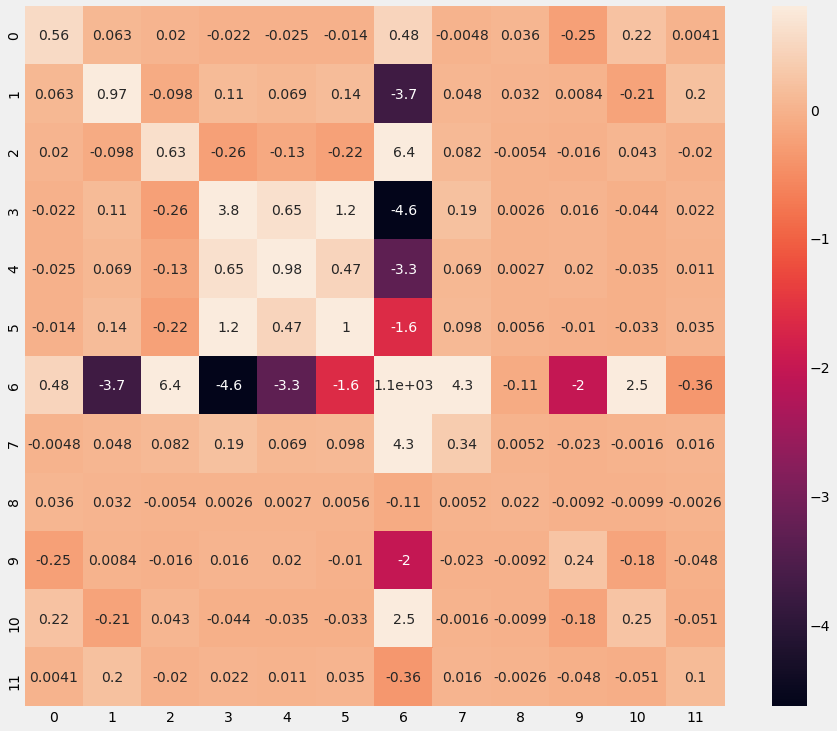

In [22]:
pca_cov = pca.get_covariance();
pca_cov = pca_cov[:12, :12]
f, ax = plt.subplots(figsize=(15,12))
sns.heatmap(pca_cov, vmax=0.8, square=True, annot=True)

In [32]:
pca_cov1 = pca.get_covariance();
pca_cov1.shape

(237, 237)

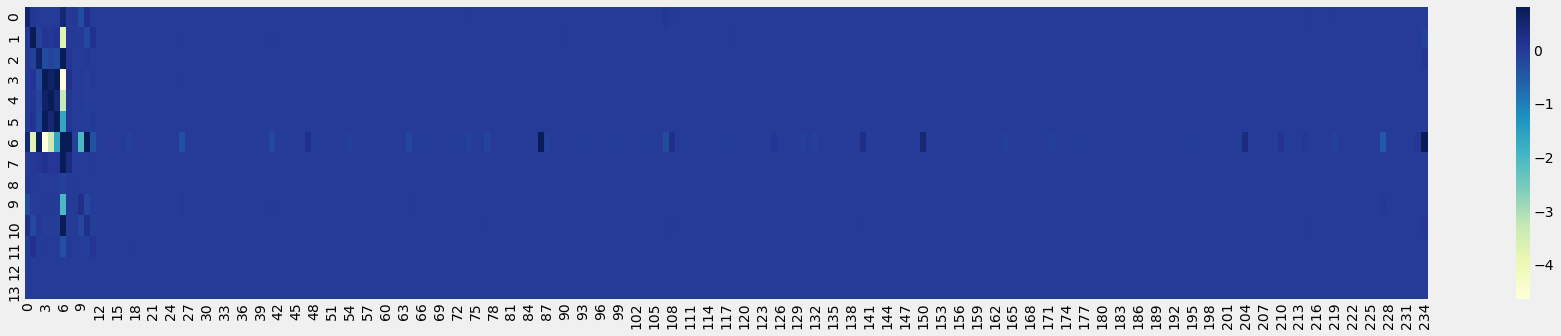

In [33]:
n_components = 235
pca_cov = pca.get_covariance();
pca_cov = pca_cov[:14, :n_components]
f, ax = plt.subplots(figsize=(28,5))
sns.heatmap(pca_cov, vmax=0.8, cmap="YlGnBu")

# t-SNE

Calculating TSNE
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 48784 samples in 14.203s...
[t-SNE] Computed neighbors for 48784 samples in 497.657s...
[t-SNE] Computed conditional probabilities for sample 1000 / 48784
[t-SNE] Computed conditional probabilities for sample 2000 / 48784
[t-SNE] Computed conditional probabilities for sample 3000 / 48784
[t-SNE] Computed conditional probabilities for sample 4000 / 48784
[t-SNE] Computed conditional probabilities for sample 5000 / 48784
[t-SNE] Computed conditional probabilities for sample 6000 / 48784
[t-SNE] Computed conditional probabilities for sample 7000 / 48784
[t-SNE] Computed conditional probabilities for sample 8000 / 48784
[t-SNE] Computed conditional probabilities for sample 9000 / 48784
[t-SNE] Computed conditional probabilities for sample 10000 / 48784
[t-SNE] Computed conditional probabilities for sample 11000 / 48784
[t-SNE] Computed conditional probabilities for sample 12000 / 48784
[t-SNE] Computed conditional 

Text(0.5, 1.0, 'TSNE[1] vs TSNE[2]')

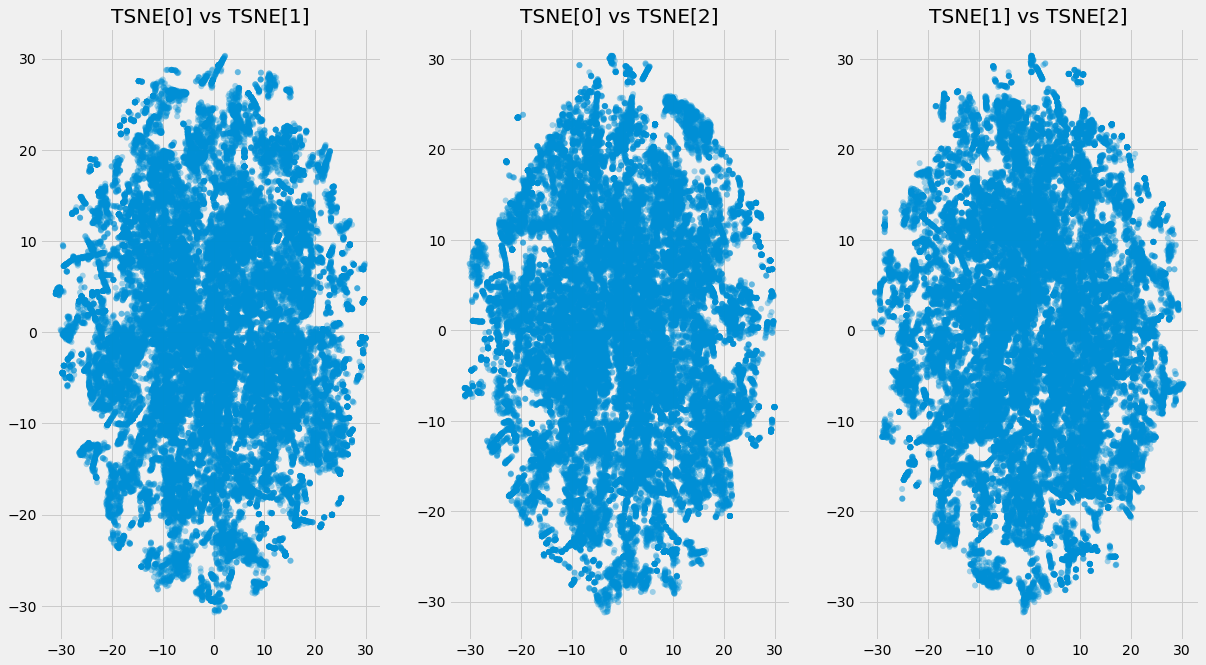

In [34]:
print("Calculating TSNE")
tsne = TSNE(n_components=3, perplexity=50, verbose=2, n_iter=1000,early_exaggeration=1)
tsne0 = tsne.fit_transform(X)

fig, axes = plt.subplots(1,3,figsize=(18.5, 10.5))

axes[0].scatter(tsne0[:,0],tsne0[:,1], 
            cmap = "coolwarm", edgecolor = "None", alpha=0.35)
axes[0].set_title('TSNE[0] vs TSNE[1]')

axes[1].scatter(tsne0[:,0],tsne0[:,2], 
            cmap = "coolwarm", edgecolor = "None", alpha=0.35)
axes[1].set_title('TSNE[0] vs TSNE[2]')

axes[2].scatter(tsne0[:,1],tsne0[:,2], 
            cmap = "coolwarm", edgecolor = "None", alpha=0.35)
axes[2].set_title('TSNE[1] vs TSNE[2]')

In [ ]:
print("Calculating TSNE")
tsne = TSNE(n_components=3, perplexity=50, verbose=2, n_iter=1000,early_exaggeration=1)
tsne0 = tsne.fit_transform(X_pca)

fig, axes = plt.subplots(1,3,figsize=(18.5, 10.5))

axes[0].scatter(tsne0[:,0],tsne0[:,1], 
            cmap = "coolwarm", edgecolor = "None", alpha=0.35)
axes[0].set_title('TSNE[0] vs TSNE[1]')

axes[1].scatter(tsne0[:,0],tsne0[:,2], 
            cmap = "coolwarm", edgecolor = "None", alpha=0.35)
axes[1].set_title('TSNE[0] vs TSNE[2]')

axes[2].scatter(tsne0[:,1],tsne0[:,2], 
            cmap = "coolwarm", edgecolor = "None", alpha=0.35)
axes[2].set_title('TSNE[1] vs TSNE[2]')

# Acknowledgements

1. [This Google Tech Talk by Laurens Van Der Maaten](https://www.youtube.com/watch?v=RJVL80Gg3lA) is a fantastic introduction to t-SNE.
2. A great reference for python code for t-SNE is [this kernel](https://www.kaggle.com/arthurtok/tsne-pca-quick-and-dirty-visuals).
3. [This blog post is a tremendously enlightening discussion of how to correctly use t-SNE.](https://distill.pub/2016/misread-tsne/)